# Image Classification

In the final part we will use what we learned earlier to classify images. 

In a first section we will go through the basics of image pre-processing and how to classify images using a fully connected network.

In the second section you will use a more sophisticated approach, namely a Convolutional Neural Network (CNN) and discover it's advantages.


## Prerequisites

In [1]:
# Before we start, load some libraries ...
from res.plot_lib import plot_data, plot_model, set_default
set_default()

In [2]:
# ... and some more
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from IPython import display
import numpy

# helper function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

### Running on a GPU: device string
Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1. Load the Dataset (MNIST)

MNIST is a famous image classifiaction dataset, consisting of grayscale images of handwritten digits.

We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [4]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

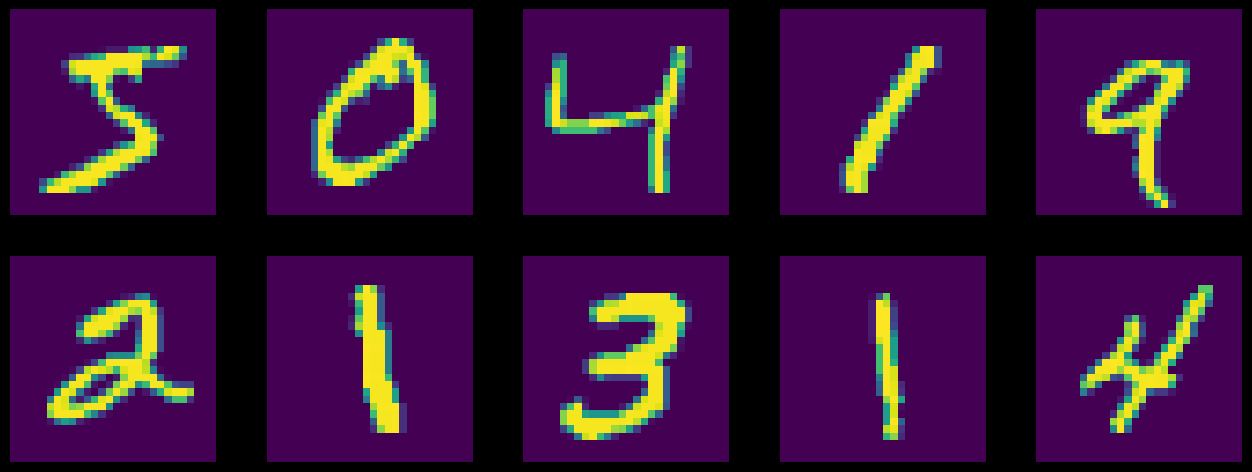

In [5]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

## 2. Training and Evaluation methods

In [6]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    dh = display.display(None, display_id=True)
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        # pass data through the model
        output = model(data)
        # calculate loss
        loss = F.nll_loss(output, target)
        # calculate gradients of the loss wrt. to model parameters
        loss.backward()
        # and update parameters accordingly
        optimizer.step()
        
        # output training status
        if batch_idx % 10 == 0:
            dh.update(f"[MODEL]: {model.__class__.__name__}, [EPOCH]: {epoch}, "
                    + f"[BATCH]: {batch_idx}, [LOSS]: {loss.item():.6f}")
            
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the prediction                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    
    print(f"Test set: Average loss: {test_loss:.4f}, "
          + f"Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)")

## 3. Classification using a Fully Connected Network

In this section we will define a Fully Connected Network and train it on a chunk of the MNIST dataset. After it has been trained we will use it to classify the remaining images, the network has not "seen" before.

### 3.1 Define a Fully Conected Network

A Fully Connected Layer (aka Linear Layer) is defined by

```fc = torch.nn.Linear(in_features, out_features, bias=True)```

In [7]:
class FCN(nn.Module):
    def __init__(self, input_size, n_features, output_size):
        super(FCN, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Flatten(), # this turns the 28x28 input image into a 784-dim vector 
            nn.Linear(in_features=input_size, out_features=n_features), 
            nn.ReLU(), 
            nn.Linear(n_features, n_features), 
            nn.ReLU(), 
            nn.Linear(n_features, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.network(x)
        


### 3.2 Train the Fully Connected Network on MNIST

In [8]:
n_hidden = 8 # number of hidden units

model_fnn = FCN(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(1, 2):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442


'[MODEL]: FCN, [EPOCH]: 1, [BATCH]: 930, [LOSS]: 0.450249'

Test set: Average loss: 0.3922, Accuracy: 8846/10000 (88%)


### In Deep Learning
* Many layers: compositionality
* Convolutions: locality + stationarity of images
* Pooling: Invariance of object class to translations

Let's use a Convolutional Neural Network (CNN)

## 4. Excercise: Classification using a Convolutional Neural Network (CNN)

* Convolutions allow us to extract prior knowledge about the images (Locality and stationarity)
* Pooling builds in some translation invariance

### 4.1 How to build a CNN

A 2D Convolutional layer is defined by:

```python
nn.Conv2d(in_channels, out_channels, kernel_size)
```
(for the full argument list see: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

A 2D MaxPooling layer is defined by:

```python
nn.MaxPool2d(kernel_size)
```
(for the full argument list see: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

A typical convolutional block consists of a convolutional layer followed by a nonlinearity (e.g. `nn.ReLU()`) and a pooling layer.

To connect a convolutinal layer (2-dim) to a fully connected layer (1-dim), we need to flatten the output of the convoltional layer.

### 4.2 Hands-On Excercise

1. Define a Convolutional Neural Network, consisting of 2 convolutional blocks and 2 fully connected layers. (Don't forget to Softmax)
  * Hint: The input_size of the first Fully Connected Layer is `n_features * 4 * 4`
2. Train your CNN on the MNIST dataset and compare the result to the FCN. 
  * Does it perform better? 
  * If it does, why?
3. Optional: What happens if you ask your CNN to classify a "rotated 1"?

In [9]:
# Excercise 1: Define CNN
class CNN(nn.Module):
    def __init__(self, input_size, n_features, output_size):
        super(CNN, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n_features, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(n_features, n_features, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(n_features*4*4, 50), 
            nn.Linear(50, output_size),  
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        return self.network(x)

In [10]:
# Excercise 2: Training and Evaluation

n_features = 6 # number of feature maps. 
# Note: 6 is chosen in order to have similar number of parameters from FCN 
# so we can compare the performace of both networks given same number of parameters.
# However, you can choose any number of feature

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(1, 2):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422


'[MODEL]: CNN, [EPOCH]: 1, [BATCH]: 930, [LOSS]: 0.140655'

Test set: Average loss: 0.1449, Accuracy: 9537/10000 (95%)


In [11]:
# Excercise 3: Pass a rotated 1 through your CNN. 

# You can use the following functions:
def gimmeOne():
    i = 0
    for data, target in test_loader.dataset:
        if target == 1:
            return data, target

def show_image(image):
    plt.figure(figsize=(3, 3))
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

def predict_single_image(model, image):
    model_cnn.eval()
    perm=torch.arange(0, 784).long()
    
    image = image.view(-1, 28*28)
    image = image[:, perm]
    image = image.view(-1, 1, 28, 28)
    
    prediction = model_cnn(image)
    return torch.argmax(prediction)

def rotate_image(image, angle):
    rot = transforms.RandomRotation((angle, angle))
    return rot(image)

# put your code here


Prediction: 1, Target: 1


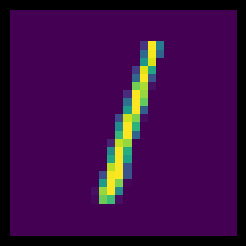

In [12]:
# get a one from the test set and predict it
image, target = gimmeOne()
show_image(image)
prediction = predict_single_image(model_cnn, image)
print(f"Prediction: {prediction}, Target: {target}")

In [ ]:
# rotate the image and predict again
img_rotated = rotate_image(image, 90)
show_image(img_rotated)
prediction = predict_single_image(model_cnn, img_rotated)
print(f"Prediction: {prediction}, Target: {target}")